In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path):
  
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    binary_image = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 11, 2
    )

    closing_kernel = np.ones((4, 4), np.uint8) 
    processed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, closing_kernel, iterations=3)

    dilation_kernel = np.ones((2, 2), np.uint8)  
    processed_image = cv2.dilate(processed_image, dilation_kernel, iterations=1)

    return image, processed_image

def split_large_boxes(stats, width_threshold=1.8, height_threshold=1.9):

    new_boxes = []
    for x, y, w, h, area in stats:
        aspect_ratio_width = w / h  
        aspect_ratio_height = h / w  

        if aspect_ratio_width > width_threshold:  
            split_w = w // 2
            new_boxes.append((x, y, split_w, h))
            new_boxes.append((x + split_w, y, split_w, h))
        
        elif aspect_ratio_height > height_threshold: 
            split_h = h // 2
            new_boxes.append((x, y, w, split_h))
            new_boxes.append((x, y + split_h, w, split_h))

        else:
            new_boxes.append((x, y, w, h))
    
    return new_boxes

def detect_characters(processed_image, min_area=70, max_area=5000, dynamic_factor=0.45, padding_ratio=0.1):


    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(processed_image, connectivity=8)
    img_h, img_w = processed_image.shape

    all_widths = [stats[i][2] for i in range(1, num_labels)]
    all_heights = [stats[i][3] for i in range(1, num_labels)]

    avg_width = np.mean(all_widths) if all_widths else 20
    avg_height = np.mean(all_heights) if all_heights else 30

    min_width = max(3, int(avg_width * dynamic_factor))
    max_width = int(avg_width * 2.5)

    min_height = max(5, int(avg_height * dynamic_factor))
    max_height = int(avg_height * 2.5)

    bounding_boxes = []
    for i in range(1, num_labels):  
        x, y, w, h, area = stats[i]
        if min_area < area < max_area and min_width < w < max_width and min_height < h < max_height:
            bounding_boxes.append((x, y, w, h, area))
    
    refined_boxes = split_large_boxes(bounding_boxes)

    final_boxes = []
    for x, y, w, h in refined_boxes:
        padding_w = int(w * padding_ratio)
        padding_h = int(h * padding_ratio)

        x_new = max(0, x - padding_w)
        y_new = max(0, y - padding_h)
        w_new = min(img_w - x_new, w + 2 * padding_w)
        h_new = min(img_h - y_new, h + 2 * padding_h)

        final_boxes.append((x_new, y_new, w_new, h_new))
    
    return final_boxes

def draw_bounding_boxes(image, bounding_boxes, color=(0, 255, 0), thickness=2):

    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(output_image, (x, y), (x + w, y + h), color, thickness)
    
    return output_image

def display_image(image, title="Adaptive Character Segmentation"):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()



<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xiong\AppData\Local\Temp\ipykernel_20464\2630830745.py:1: SyntaxWarning: invalid escape sequence '\R'
  image_path = "output\RC04844\page_4.png"  # Change this to the correct image path


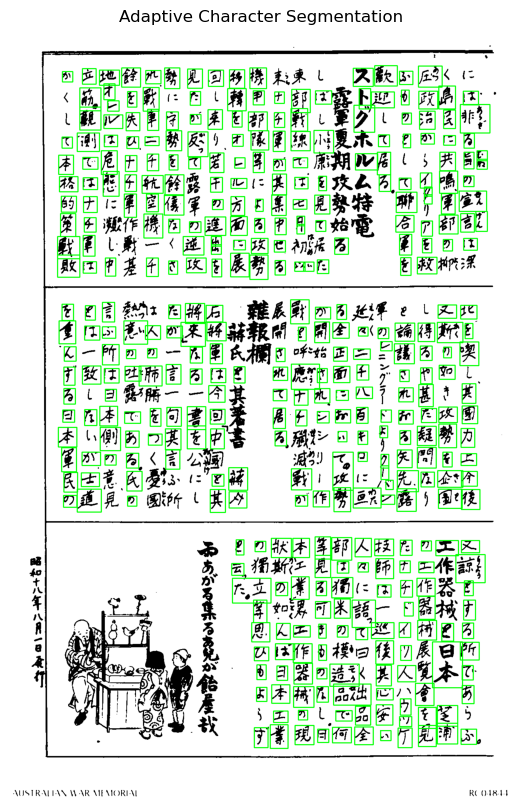

In [ ]:
image_path = "output\RC04844\page_4.png"  
original_image, processed_image = load_and_preprocess_image(image_path)
   
character_boxes = detect_characters(processed_image)
output_image_segmented = draw_bounding_boxes(original_image, character_boxes)
display_image(output_image_segmented)